# EAA Summer School in Computational Acoustics 2021


## Higher order elements

The objective of this tutorial is to present higher-order elements.
We will consider the same problem of computing 1D resonance modes as in the first tutorial where the convergence of linear and quadratic elements was studied. 

### Preamble

We begin by loading a number of standard modules such as `numpy` and `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.special import legendre

We define the sound speed as well as the length of the duct

In [2]:
c_0 = 340
L = np.pi * c_0

In each element, the solution is approximated as a linear combination of Lobatto polynomials.
These shape functions are defined as follows:
$$ N_0(\xi)=\dfrac{1-\xi}{2},\quad N_1(\xi)=\dfrac{1+\xi}{2} ,N_q(\xi)=\dfrac{1+\xi}{2}\quad N_q=\displaystyle{\int_{-1}^{\xi}} L_{q-1}(x) dx,$$
where $L_q$ is the Legendre polynomial of order $q$.
We can create a function that returns an array of Lobatto polynomials:

In [3]:
def Lobatto(n):
    L = []
    L.append(np.poly1d([-1/2, 1/2]))
    for i_n in range(1, n):
        p = np.polyint(legendre(i_n))
        L.append(p-p(-1))   # Integration constant to have L(-1)=0
    L.append(np.poly1d([1/2, 1/2]))
    return L

We can plot the first Lobatto function. You can modify the value of $n$.

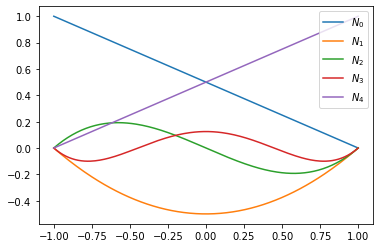

In [4]:
n = 4
N = Lobatto(n)
x = np.linspace(-1,1,200)
plt.figure()
for i in range(n+1):
    plt.plot(x,N[i](x),label='$N_{}$'.format(i))
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
What is the difference between the three shape functions associated to Lobatto at order 2 and the one of quadratic nodal elements?
Explain why Lobatto polynomials are called hierarchical.

The function to create the elementary mass and stiffness matrices is as follows

In [5]:
def Elementary_matrices(order, h):
    N = Lobatto(order)
    K_elem = np.zeros((order+1, order+1))
    M_elem = np.zeros((order+1, order+1))
    for ii in range(order+1):
        for jj in range(order+1):
            temp = np.polyint(N[ii]*N[jj])
            M_elem[ii, jj] = temp(1)-temp(-1)
            temp = np.polyint(np.polyder(N[ii])*np.polyder(N[jj]))
            K_elem[ii, jj] = temp(1)-temp(-1)
    M_elem = (h/2/c_0**2)*M_elem
    K_elem = (2/h)*K_elem
    return M_elem, K_elem

<div class="alert alert-block alert-info">
In this function, the integration is done analyticaly.
You can modify it to use a numerical integration as presented in the other tutorial.

We can define an error function that compute, for a given mode, the error between the numerical and analytical values

In [6]:
def compute_error(n,order,n_mode):
    delta = L/n
    M_e,K_e = Elementary_matrices(order, delta)
    nb_dof = (n+1)+n*(order-1)
    K = np.zeros((nb_dof,nb_dof))
    M = np.zeros((nb_dof,nb_dof))
    for ie in range(n): # loop on the elements
        dof = slice(order*ie, order*ie+order+1) # indices of the local dofs
        K[dof,dof] += K_e
        M[dof,dof] += M_e
    omega = np.sort(np.sqrt(eigs(K, n_mode, M,which='SM',return_eigenvectors=False)))
    error = np.absolute(omega[-1]-n_mode+1) 
    return error

In [7]:
n = 4
order = 2
compute_error(10,4,3)

9.462777228463892e-10

<div class="alert alert-block alert-info">
By using the following script, what can you say about the order of convergence of these high-order elements?
You can test on modes 3 and 7 for instance. What can we say, for higher modes, in the zone corresponding to coarse meshes?

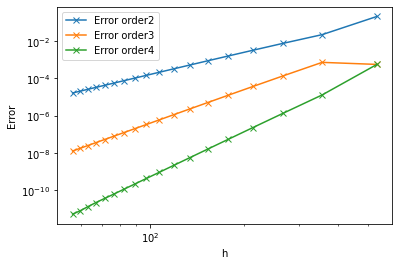

In [8]:
n_max = 20
h = np.zeros(n_max)
current_mode = 3
tab_order = [2,3,4]
eps = np.zeros((len(tab_order),n_max))
for i_order in range(len(tab_order)): 
    for i_n in range(2,n_max):
        h[i_n] = L/i_n 
        eps[i_order,i_n] = compute_error(i_n,tab_order[i_order],current_mode)
plt.figure()
for i_order in range(len(tab_order)):
    plt.loglog(h[2:],eps[i_order,2:], 'x-',label='Error order{}'.format(tab_order[i_order]))

plt.xlabel('h') ; 
plt.ylabel('Error') 
plt.legend()
plt.show()